# Keras Autoencoder with Annoy for CBIR

## Black and White 32x64 pixels, 4x8x128 encoder convolutions, GlobalAverage to 128 dimensions

In [1]:
import keras
keras.__version__

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.2.2'

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1097997821965421523
]


In [3]:
import tensorflow as tf
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456)]

In [4]:
from keras import backend as K
#K.tensorflow_backend._get_available_gpus()

# Train model

## Training variables

In [5]:

#target_image_size = (64,112)
target_image_size = (32,64)

color_mode='grayscale' # 'grayscale' or 'rgb'

if color_mode=='grayscale':
    target_image_size_3D = (target_image_size[0], target_image_size[1], 1)
else: #then rgb
    target_image_size_3D = (target_image_size[0], target_image_size[1], 3)

batch_size_training = 32
batch_size_validation = 32

# Directories
image_dir_training ='data_bw_with_rotations/train'
image_dir_validation = 'data_bw_with_rotations/validate'
image_dir_testing = 'data_bw_with_rotations/test'
image_dir_samples = image_dir_testing

# Training variables
training_steps_per_epoch = 200
training_number_of_epoch = 5
validation_steps = 100

# Model name to save
model_name='autoencoder_bw'

# Model name to load for Testing
model_name_pretrained = model_name

# Encoder model name
model_name_encoder = model_name + '-encoder'

In [6]:
# Testing variables

In [7]:
# Import required items for training
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D, Dense, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras import callbacks
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
import numpy as np


from sklearn.metrics import label_ranking_average_precision_score
import time

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


## Convenience functions

In [8]:
# Unfortunately, matplotlib, cv2, etc only print in greyscale 
#   when you have 3 color axes (RGB) all set to make the image look grey.
#   But Keras loads greyscale images with only a single number (to optimize training, etc)
#   So, we need to convert any Keras greyscale images to have 3 values

def display_image(single_image):
    #check to see if image is rgb
    if (np.shape(single_image)[-1]==3):
        plt.imshow(single_image)
    if (np.shape(single_image)[-1]==1):
        si = np.concatenate((single_image,single_image,single_image), axis=2)
        plt.imshow(si)
        
def get_image(single_image):
    #check to see if image is rgb
    if (np.shape(single_image)[-1]==3):
        return single_image
    if (np.shape(single_image)[-1]==1):
        si = np.concatenate((single_image,single_image,single_image), axis=2)
        return si
    

## ImageDataGenerators 

In [9]:
# Created the Train and Validation image generators

# Load the data (in that case MNIST)
train_datagen = ImageDataGenerator(
        #shear_range=0.05,
        #zoom_range=0.01,
        #rotation_range=5.00,
        #height_shift_range=0.10,
        #width_shift_range=0.10,
        rescale=1. / 255,
        horizontal_flip=False)

validation_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
        image_dir_training,
        target_size=target_image_size,
        batch_size=batch_size_training,
        class_mode='input',
        color_mode=color_mode)

validation_generator = validation_datagen.flow_from_directory(
        image_dir_validation,
        target_size=target_image_size,
        batch_size=batch_size_validation,
        class_mode='input',
        color_mode=color_mode)



Found 722 images belonging to 1 classes.
Found 191 images belonging to 1 classes.


In [57]:
def convertAllNonWhiteToBW(single_image):
    si = single_image
    si[si!=255]=0
    #si.setflags(write=1)
    return si

Found 96 images belonging to 1 classes.


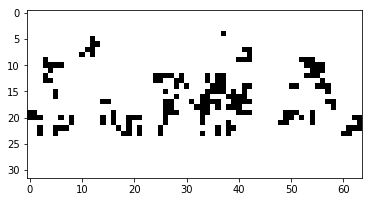

In [61]:
# Create an Sample image generator and get sample images to use throughout all the training for visualization


# Create callback function to use later.
sample_datagen = ImageDataGenerator(rescale=1. / 255,
        preprocessing_function=convertAllNonWhiteToBW)

sample_generator = sample_datagen.flow_from_directory(
        image_dir_samples,
        target_size=target_image_size,
        batch_size=16,
        class_mode='input',
        color_mode=color_mode)

next_batch = next(sample_generator)
sample_images = next_batch[0]
test_image=sample_images[1]
ti = test_image

#ti[ti!=1]=0

display_image(ti)




## Define Model for Training - Architecture

In [18]:
def define_model():
    
    
    #Input
    input_img = Input(shape=target_image_size_3D, name='input')  # adapt this if using `channels_first` image data format
    
     # Layer 10
    x = Conv2D(16, (3, 3), activation='relu', padding='same', strides=(1,1))(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Layer 20
    x = Conv2D(32, (3, 3), activation='relu', padding='same', strides=(1,1))(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    
#    # Added
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
#    
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)

    # Layer 30

#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = MaxPooling2D((2, 2), padding='same')(x)
    
    # Layer 40
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same', name='encoder')(x)

    # at this point the representation is (4, 4, 8) i.e. 128-dimensional

    # Uplayer 40
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    
    # Uplayer 30
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)


#    #Added
#    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)  
#    
#    x = Conv2D(32, (3, 3), activation='relu')(x)
#    #x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
#    x = UpSampling2D((2, 2))(x)  
    
    # Uplayer 20
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Uplayer 10
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    
    # Output
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='decoded')(x)


    autoencoder = Model(input_img, outputs=decoded)
    autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

    print(autoencoder.outputs)
        
    return autoencoder
    

In [19]:
# Create callback to write sample images to disk
class ProgressCallback(callbacks.Callback):
    
    def __init__(self, sample_image):
        self.sample_image = sample_image
        self.image4d = self.sample_image[None,:] # predict needs a batch of images (shape=4). This adds a dimension  
        
    def on_epoch_end(self, epoch, logs={}):
        
        processed_images = self.model.predict(x=[self.image4d],batch_size=1)
         
        # plot the image and save it
        f = plt.figure()
        f.add_subplot(1, 2, 1)  # this line outputs images side-by-side
        sim = get_image(self.sample_image)
        plt.imshow(sim)
        f.add_subplot(1, 2, 2)  # this line outputs images side-by-side
        pim = get_image(processed_images[0])
        plt.imshow(pim)
        plt.suptitle('Epoch ' + str(epoch))
        filename = 'epoch-' + str(epoch) + '.png'
        plt.savefig(filename)
        plt.close()
        #plt.show()


In [20]:
# Train the model
def train_model(model_to_train):
    progress = ProgressCallback(sample_image=sample_images[0])
    early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')
    model_to_train.fit_generator(
        train_generator,
        steps_per_epoch=training_steps_per_epoch,
        epochs=training_number_of_epoch,
        validation_data=validation_generator,
        validation_steps=validation_steps,
        callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False),progress,early_stop])
    
    model_to_train.save(model_name + '.h5')
    
    return model_to_train

In [21]:
#autoencoder.save('autoencoder_8by14by128.h5')

In [22]:
# Train the model
x = define_model()

[<tf.Tensor 'decoded/Sigmoid:0' shape=(?, 32, 64, 1) dtype=float32>]


In [23]:
print(x.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 32, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 16)        416       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 32, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 16, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 16, 128)        36992     
_________________________________________________________________
encoder (MaxPooling2D)       (None, 4, 8, 128)         0         
__________

In [29]:
# Show encoder output size (before global pooling)
e = x.get_layer('encoder')
e.output

<tf.Tensor 'encoder_1/MaxPool:0' shape=(?, 4, 8, 128) dtype=float32>

In [30]:
autoencoder = x
autoencoder = train_model(autoencoder)

Epoch 1/5
200/200 [==============================] - 26s 131ms/step - loss: 0.1428 - val_loss: 0.1296
Epoch 2/5
200/200 [==============================] - 27s 134ms/step - loss: 0.1188 - val_loss: 0.1272
Epoch 3/5
200/200 [==============================] - 26s 130ms/step - loss: 0.1144 - val_loss: 0.1340
Epoch 4/5
200/200 [==============================] - 26s 132ms/step - loss: 0.0973 - val_loss: 0.1028
Epoch 5/5
200/200 [==============================] - 26s 129ms/step - loss: 0.0826 - val_loss: 0.0971


In [126]:
#!pip3 install jupyter-tensorboard
for i in range(3):
    pass
    #autoencoder = train_model(x)

In [31]:
for i in range(50):
    autoencoder = train_model(x)
    #pass

Epoch 1/5
200/200 [==============================] - 28s 141ms/step - loss: 0.0760 - val_loss: 0.0874
Epoch 2/5
200/200 [==============================] - 27s 133ms/step - loss: 0.0716 - val_loss: 0.0841
Epoch 3/5
200/200 [==============================] - 26s 129ms/step - loss: 0.0682 - val_loss: 0.0811
Epoch 4/5
200/200 [==============================] - 26s 128ms/step - loss: 0.0655 - val_loss: 0.0793
Epoch 5/5
200/200 [==============================] - 26s 128ms/step - loss: 0.0632 - val_loss: 0.0770
Epoch 1/5
200/200 [==============================] - 26s 129ms/step - loss: 0.0611 - val_loss: 0.0843
Epoch 2/5
200/200 [==============================] - 26s 130ms/step - loss: 0.0589 - val_loss: 0.0730
Epoch 3/5
200/200 [==============================] - 26s 130ms/step - loss: 0.0571 - val_loss: 0.0712
Epoch 4/5
200/200 [==============================] - 26s 129ms/step - loss: 0.0551 - val_loss: 0.0708
Epoch 5/5
200/200 [==============================] - 26s 129ms/step - loss: 0.0533

200/200 [==============================] - 29s 144ms/step - loss: 0.0124 - val_loss: 0.1154
Epoch 2/5
200/200 [==============================] - 29s 143ms/step - loss: 0.0127 - val_loss: 0.1174
Epoch 3/5
200/200 [==============================] - 29s 144ms/step - loss: 0.0125 - val_loss: 0.1171
Epoch 4/5
200/200 [==============================] - 29s 145ms/step - loss: 0.0125 - val_loss: 0.1308
Epoch 5/5
200/200 [==============================] - 28s 142ms/step - loss: 0.0131 - val_loss: 0.1173
Epoch 1/5
200/200 [==============================] - 29s 143ms/step - loss: 0.0126 - val_loss: 0.1186
Epoch 2/5
200/200 [==============================] - 28s 142ms/step - loss: 0.0124 - val_loss: 0.1177
Epoch 3/5
200/200 [==============================] - 29s 143ms/step - loss: 0.0138 - val_loss: 0.1168
Epoch 4/5
200/200 [==============================] - 29s 143ms/step - loss: 0.0122 - val_loss: 0.1187
Epoch 5/5
200/200 [==============================] - 28s 142ms/step - loss: 0.0123 - val_los

KeyboardInterrupt: 

# Test the model

In [32]:
# Import needed libraries
import numpy as np
from keras.models import Model
from keras.datasets import mnist
#import cv2
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator






In [34]:
# Load the model trained above
print('Loading model :')
t0 = time.time()
autoencoder = load_model(model_name_pretrained + '.h5')
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('encoder').output)
t1 = time.time()
print('Model loaded in: ', t1-t0)


Loading model :
Model loaded in:  1.8898301124572754


# Convenience methods

In [35]:
class all_directory_images_generator:
    def __init__(self, sourcedir='data_with_rotations/test', batch_size=16, color_mode='grayscale', target_image_size=(100,100)):
        self.batch_size = batch_size
        self.sourcedir = sourcedir
        self.color_mode = color_mode
        self.target_image_size = target_image_size
        
        self.test_datagen = ImageDataGenerator(rescale=1. / 255)
        self.test_generator = self.test_datagen.flow_from_directory(
                sourcedir,
                target_size=target_image_size,
                batch_size=self.batch_size,
                class_mode='input',
                color_mode=self.color_mode,
                shuffle=False)
        
        self.n = self.test_generator.n
        self.filenames = self.test_generator.filenames   
        self.current_batch = 0
        self.max_batch = int(self.n / self.batch_size)
        
    def __iter__(self):
        return self

    def __next__(self):
        bi = self.test_generator.batch_index
        bs = self.test_generator.batch_size
        batch_file_names = self.test_generator.filenames[bi*bs:bi*bs+bs]
        return (next(self.test_generator), batch_file_names)



# Create encoder model

In [36]:
# Create a new model from the autoencoder, only up to the embedding layer
enc_model = Model(autoencoder.input, autoencoder.get_layer('encoder').output)

x1 = enc_model.get_layer('encoder').output
#x1 = GlobalMaxPooling2D(name='flat')(x1)
x1 = GlobalAveragePooling2D(name='flat')(x1)
encoder = Model(enc_model.input, x1)

# save the model to disk for reuse later
encoder.save(model_name_encoder + '.h5')



In [37]:
# Create dictionary with all filenames (keys) and predicted encodings (values)
image_encoding_dict = {}

test_images = all_directory_images_generator(batch_size=16, target_image_size=target_image_size, sourcedir=image_dir_testing)
bs = test_images.batch_size

for i in range(test_images.max_batch):
    images_both_x_and_y, names = next(test_images)
    images = images_both_x_and_y[0]
    encodings = encoder.predict(images,batch_size=bs)
    for j in range(bs):
        image_encoding_dict[names[j]]=encodings[j]
        


# Create dictionary with index integers (keys) and filenames (values)
#   This is needed later for Annoy, since it uses integers as item keys, and we have to map back to a filename
image_filename_dict = {}

i = 0
for key, value in image_encoding_dict.items():
    image_filename_dict[i]=key
    i = i+1



Found 96 images belonging to 1 classes.


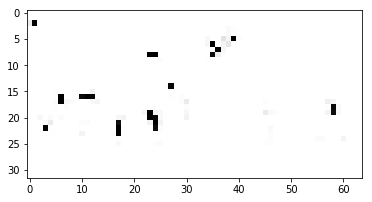

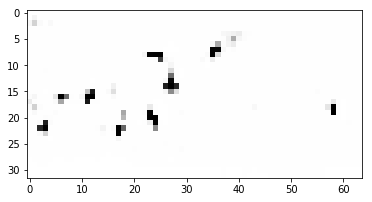

images/233.jpg


In [39]:
# Let's just view a few input images and output images from the autoencoder
#   This includes the decoder part of the autoencoder, so we'll still see an image

next_batch, next_filenames = next(test_images) # Use the test_images defined above
#next_batch = next(test_generator)
images = next_batch[0]
first_image=images[0]
second_image=images[1]

plt.imshow(get_image(first_image))
plt.show()

#plt.imshow(second_image)
#plt.show()

recreated_pill = autoencoder.predict(x=images,batch_size=32)

plt.imshow(get_image(recreated_pill[0]))
plt.show()
print(next_filenames[0])



# Get a feel for the outputs

In [40]:
# Load a dataframe from the dictionary
import pandas as pd
df = pd.DataFrame.from_dict(image_encoding_dict, orient='index')

#df['filename'] = df.index
#df['image']= df['filename'].apply(lambda x: x.split('/')[-1])
#HOLY COW!  All of these are so close together. :-(  Can't differentiate one from another easily - Deeper network help?
#df.to_csv('96_images_32x64_AvgPool_4x8.csv')

df

0         1         2         3         4    \
images/229.jpg      1.284578  0.007712  0.401936  1.351697  0.955220   
images/229_196.jpg  1.490508  0.034850  0.401691  1.222162  0.907600   
images/229_262.jpg  1.225986  0.003114  0.306598  1.018006  0.807950   
images/229_45.jpg   1.422446  0.043830  0.451098  1.233640  1.018847   
images/230.jpg      0.914557  0.329994  0.698131  0.880333  0.914578   
images/230_200.jpg  0.772726  0.314545  0.535248  0.924802  0.830744   
images/230_287.jpg  0.999026  0.285296  0.655100  0.887072  0.864568   
images/230_341.jpg  0.818208  0.237177  0.540899  0.713062  1.048231   
images/231.jpg      1.256284  0.224937  0.507603  1.047830  0.793727   
images/231_212.jpg  0.836662  0.247364  0.685984  1.220316  1.001398   
images/231_56.jpg   0.998230  0.089868  0.452381  0.950947  0.665750   
images/231_80.jpg   0.965964  0.259177  0.475447  0.789090  0.825846   
images/232.jpg      1.326128  0.143277  0.580816  1.057769  0.951630   
images/232_202.jpg  1.261832  0.098885  0.636387  1.009193  0.991493   
images/232_251.jpg  1.128256  0.176803  0.623949  0.977984  0.877344   
images/232_327.jpg  1.328211  0.114145  0.584220  0.969501  0.968317   
images/233.jpg      0.725399  0.364092  0.534524  0.661253  0.758138   
images/233_207.jpg  1.083103  0.246460  0.571100  0.735896  0.680221   
images/233_337.jpg  0.798098  0.385602  0.554552  0.561680  0.724766   
images/233_83.jpg   0.838308  0.282705  0.714393  0.899423  0.683193   
images/234.jpg      0.926179  0.205897  0.636603  0.972517  0.913951   
images/234_100.jpg  0.885147  0.152780  0.472593  1.007955  0.761500   
images/234_142.jpg  0.888108  0.222258  0.509073  0.967731  0.828814   
images/234_319.jpg  1.025518  0.214939  0.590740  0.931293  0.801962   
images/235.jpg      1.453592  0.012919  0.508757  1.148004  0.867635   
images/235_149.jpg  1.330037  0.015060  0.599719  1.157090  0.982985   
images/235_328.jpg  1.229239  0.051304  0.750797  1.244603  0.818977   
images/235_74.jpg   1.386037  0.027985  0.583195  1.272140  0.553531   
images/236.jpg      0.716425  0.265650  0.691846  0.709983  0.752949   
images/236_26.jpg   0.608184  0.251447  0.811270  0.596009  0.850196   
...                      ...       ...       ...       ...       ...   
images/245_227.jpg  1.263247  0.160372  0.532442  1.095082  0.850180   
images/245_51.jpg   0.993648  0.130008  0.526356  1.194595  1.083907   
images/246.jpg      1.191093  0.140423  0.373855  1.191134  0.786211   
images/246_189.jpg  0.798316  0.220226  0.523816  1.330739  0.892328   
images/246_216.jpg  0.904512  0.126618  0.490712  1.175196  1.210081   
images/246_331.jpg  1.159403  0.159972  0.566226  1.157965  0.873649   
images/247.jpg      0.810736  0.224222  0.582209  0.619570  0.741666   
images/247_310.jpg  0.888389  0.231471  0.682587  0.735797  0.978317   
images/247_335.jpg  0.997608  0.220236  0.527653  0.729234  0.984448   
images/247_345.jpg  0.937751  0.218051  0.694810  0.733169  0.693462   
images/248.jpg      1.109531  0.138827  0.522423  1.375019  0.813879   
images/248_104.jpg  1.081938  0.094437  0.500464  1.114725  0.733026   
images/248_175.jpg  1.227371  0.046589  0.369322  1.227290  0.618856   
images/248_7.jpg    1.211339  0.116617  0.463716  1.031822  0.964803   
images/249.jpg      1.241705  0.235128  0.597779  0.981907  0.698398   
images/249_132.jpg  1.153624  0.131001  0.427077  1.138408  0.784339   
images/249_153.jpg  0.951748  0.252906  0.454759  0.871767  0.856873   
images/249_335.jpg  1.067801  0.160163  0.644056  1.104728  0.863409   
images/250.jpg      1.163091  0.069312  0.558606  0.983773  1.207628   
images/250_118.jpg  1.098189  0.129592  0.612276  0.877222  1.175009   
images/250_323.jpg  1.024366  0.092517  0.602112  1.049976  0.969075   
images/250_331.jpg  1.040752  0.122363  0.568310  0.757333  0.780572   
images/251.jpg      0.640702  0.442170  0.452855  0.889741  0.630791   
images/251_327.jpg  0.544990  0.436324  0.569253  0.363263  0.451

In [41]:
# Look at the simple statistics around the encodings
dfstat = df.describe()
dfstat

0          1          2          3          4          5    \
count  96.000000  96.000000  96.000000  96.000000  96.000000  96.000000   
mean    1.080462   0.171231   0.549726   0.990880   0.867665   0.713988   
std     0.247962   0.113153   0.106953   0.254223   0.174675   0.118392   
min     0.524433   0.000000   0.306598   0.363263   0.418985   0.452156   
25%     0.906213   0.086956   0.473035   0.830850   0.760659   0.638983   
50%     1.082932   0.152899   0.534886   0.984040   0.860141   0.706463   
75%     1.256783   0.235640   0.604653   1.162273   0.982961   0.793382   
max     1.735602   0.513407   0.818168   1.738025   1.351109   0.957462   

             6          7          8          9      ...            118  \
count  96.000000  96.000000  96.000000  96.000000    ...      96.000000   
mean    0.910561   0.559751   0.705154   0.720442    ...       0.997100   
std     0.136905   0.152612   0.154546   0.112224    ...       0.204693   
min     0.617631   0.132983   0.174236   0.432152    ...       0.486509   
25%     0.811508   0.484453   0.606130   0.644912    ...       0.849327   
50%     0.909334   0.556939   0.722112   0.713905    ...       1.013688   
75%     0.992836   0.671667   0.807456   0.791606    ...       1.135401   
max     1.250338   0.976752   1.005575   1.021497    ...       1.404700   

             119        120        121        122        123        124  \
count  96.000000  96.000000  96.000000  96.000000  96.000000  96.000000   
mean    0.786396   0.320019   1.038312   0.896489   0.867774   1.196638   
std     0.232145   0.120672   0.180722   0.331558   0.172182   0.293182   
min     0.279390   0.087931   0.523388   0.150080   0.497534   0.471352   
25%     0.631921   0.226718   0.922281   0.683975   0.753247   1.001696   
50%     0.749974   0.313739   1.030991   0.844355   0.842658   1.197190   
75%     0.946861   0.404918   1.151019   1.027354   1.010492   1.406759   
max     1.383227   0.618140   1.423521   1.706410   1.256053   1.885213   

             125        126        127  
count  96.000000  96.000000  96.000000  
mean    0.946608   0.189233   0.729908  
std     0.208743   0.086993   0.158566  
min     0.426736   0.034665   0.284875  
25%     0.800567   0.124146   0.617273  
50%     0.942949   0.199419   0.724804  
75%     1.112487   0.239021   0.821363  
max     1.444994   0.426498   1.093178  

[8 rows x 128 columns]

In [42]:
# See how they all cluster
from sklearn.cluster import KMeans

number_of_clusters=24
km = KMeans(n_clusters=number_of_clusters)
# Normally people fit the matrix
km.fit(df)
print(km.labels_)

[ 9  9  9  9 19 23 19 23 20 20  8 23 13 13 20 13  8  8  8  8  6  6  6  6
 21 21 21 21 23 23  8  0  7  7  7  7 16 16 16 16  4  4  4  4  4 18 18 18
 14 14 14 14  2  2  2  2  5  5  5  5  7  7  7  7 10 10 10 10 22 15 15 22
  3 19  3 19 17 17 17 11 11 11  8 11  1  1  1  1  0  0  0  0 12 12 12 12]


In [43]:
# Convert results to a dataframe - note that to get the index / filename, I had to include the first column
results = pd.DataFrame({
    'ignore': df[0],
    'category': km.labels_
})
results

ignore  category
images/229.jpg      1.284578         9
images/229_196.jpg  1.490508         9
images/229_262.jpg  1.225986         9
images/229_45.jpg   1.422446         9
images/230.jpg      0.914557        19
images/230_200.jpg  0.772726        23
images/230_287.jpg  0.999026        19
images/230_341.jpg  0.818208        23
images/231.jpg      1.256284        20
images/231_212.jpg  0.836662        20
images/231_56.jpg   0.998230         8
images/231_80.jpg   0.965964        23
images/232.jpg      1.326128        13
images/232_202.jpg  1.261832        13
images/232_251.jpg  1.128256        20
images/232_327.jpg  1.328211        13
images/233.jpg      0.725399         8
images/233_207.jpg  1.083103         8
images/233_337.jpg  0.798098         8
images/233_83.jpg   0.838308         8
images/234.jpg      0.926179         6
images/234_100.jpg  0.885147         6
images/234_142.jpg  0.888108         6
images/234_319.jpg  1.025518         6
images/235.jpg      1.453592        21
images/235_149.jpg  1.330037        21
images/235_328.jpg  1.229239        21
images/235_74.jpg   1.386037        21
images/236.jpg      0.716425        23
images/236_26.jpg   0.608184        23
...                      ...       ...
images/245_227.jpg  1.263247        10
images/245_51.jpg   0.993648        10
images/246.jpg      1.191093        22
images/246_189.jpg  0.798316        15
images/246_216.jpg  0.904512        15
images/246_331.jpg  1.159403        22
images/247.jpg      0.810736         3
images/247_310.jpg  0.888389        19
images/247_335.jpg  0.997608         3
images/247_345.jpg  0.937751        19
images/248.jpg      1.109531        17
images/248_104.jpg  1.081938        17
images/248_175.jpg  1.227371        17
images/248_7.jpg    1.211339        11
images/249.jpg      1.241705        11
images/249_132.jpg  1.153624        11
images/249_153.jpg  0.951748         8
images/249_335.jpg  1.067801        11
images/250.jpg      1.163091         1
images/250_118.jpg  1.098189         1
images/250_323.jpg  1.024366         1
images/250_331.jpg  1.040752         1
images/251.jpg      0.640702         0
images/251_327.jpg  0.544990         0
images/251_355.jpg  0.524433         0
images/251_48.jpg   0.579543         0
images/252.jpg      1.092421        12
images/252_135.jpg  1.019808        12
images/252_68.jpg   0.829056        12
images/252_75.jpg   0.922968        12

[96 rows x 2 columns]

In [44]:
#show the distance between images
#  should be small distances between rotated images - ideally zero
from scipy.spatial.distance import squareform, pdist
distdf = pd.DataFrame(squareform(pdist(df.iloc[:, 1:])), columns = df.index.unique(), index=df.index.unique()) #, columns=df['image'].unique(), index=df['image'].unique())
distdf

images/229.jpg  images/229_196.jpg  images/229_262.jpg  \
images/229.jpg            0.000000            1.343944            1.728883   
images/229_196.jpg        1.343944            0.000000            1.553920   
images/229_262.jpg        1.728883            1.553920            0.000000   
images/229_45.jpg         1.066238            1.554479            1.776472   
images/230.jpg            3.807782            3.688216            3.364406   
images/230_200.jpg        4.072196            3.995826            3.536237   
images/230_287.jpg        3.615152            3.592014            3.189357   
images/230_341.jpg        3.859485            3.817127            3.287038   
images/231.jpg            2.961524            2.874135            2.545611   
images/231_212.jpg        3.431247            3.344173            3.114314   
images/231_56.jpg         3.251575            3.235749            2.741190   
images/231_80.jpg         4.183407            4.126840            3.510403   
images/232.jpg            2.520166            2.419049            2.492587   
images/232_202.jpg        2.640191            2.624464            2.383658   
images/232_251.jpg        2.982125            2.951026            2.603846   
images/232_327.jpg        2.498979            2.421817            2.373487   
images/233.jpg            4.057508            4.028293            3.462200   
images/233_207.jpg        3.425317            3.434575            2.837596   
images/233_337.jpg        4.170984            4.114790            3.617467   
images/233_83.jpg         3.586456            3.586592            3.079650   
images/234.jpg            3.106311            3.206788            2.657488   
images/234_100.jpg        2.664533            2.649086            2.269911   
images/234_142.jpg        2.720616            2.650852            2.404023   
images/234_319.jpg        2.871005            2.894385            2.530504   
images/235.jpg            1.869780            1.702135            1.767838   
images/235_149.jpg        1.720028            1.707502            1.582331   
images/235_328.jpg        1.593061            1.657510            2.022079   
images/235_74.jpg         1.744965            1.649847            1.770974   
images/236.jpg            4.126176            4.085033            3.625480   
images/236_26.jpg         4.371909            4.343724            3.758645   
...                            ...                 ...                 ...   
images/245_227.jpg        2.876055            2.562254            2.654819   
images/245_51.jpg         2.927100            2.792084            2.720436   
images/246.jpg            2.355605            2.056332            2.123535   
images/246_189.jpg        2.614607            2.638196            2.401683   
images/246_216.jpg        2.650771            2.605411            2.216520   
images/246_331.jpg        2.320165            2.207634            2.191040   
images/247.jpg            3.937491            3.823697            3.212520   
images/247_310.jpg        3.959544            3.812294            3.408345   
images/247_335.jpg        3.382404            3.182138            2.741621   
images/247_345.jpg        3.928998            3.770836            3.433096   
images/248.jpg            1.875428            1.830951            1.974375   
images/248_104.jpg        2.393319            2.429281            2.257361   
images/248_175.jpg        2.148351            2.137562            2.043767   
images/248_7.jpg          2.231866            2.148442            1.806648   
images/249.jpg            2.592230            2.586850            2.252179   
images/249_132.jpg        2.417014            2.443744            2.005382   
images/249_153.jpg        3.413608            3.374037            2.917672   
images/249_335.jpg        2.776923            2.739266            2.389758   
images/250.jpg            2.032736            1.899171            1.909071   
images/250_118.jpg        2.587740        

In [45]:
# Show the covariance between the columns - not useful since it's unscaled. :-(
#covdf = df.cov()*10000 #, columns = df.index.unique(), index=df.index.unique()) #, columns=df['image'].unique(), index=df['image'].unique())
#covdf

In [46]:
# Show the correlation between the columns (which represent a global pool from the encoder convolutions)
#   Correlation appears high, likely could do some PCA, but seems like tuning the autoencoder should be able to do that
corrdf = df.corr() #, columns = df.index.unique(), index=df.index.unique()) #, columns=df['image'].unique(), index=df['image'].unique())
corrdf

0         1         2         3         4         5         6    \
0    1.000000 -0.748669 -0.434128  0.584825  0.358987 -0.143041  0.492288   
1   -0.748669  1.000000  0.334979 -0.600621 -0.439500  0.153391 -0.383420   
2   -0.434128  0.334979  1.000000 -0.233666 -0.115095  0.302059 -0.097984   
3    0.584825 -0.600621 -0.233666  1.000000  0.274255 -0.255367  0.498461   
4    0.358987 -0.439500 -0.115095  0.274255  1.000000  0.170959  0.311680   
5   -0.143041  0.153391  0.302059 -0.255367  0.170959  1.000000 -0.133224   
6    0.492288 -0.383420 -0.097984  0.498461  0.311680 -0.133224  1.000000   
7    0.657840 -0.609570  0.013619  0.616383  0.368238 -0.057443  0.428780   
8    0.690556 -0.669790 -0.311389  0.752009  0.391456 -0.140672  0.541781   
9    0.249751 -0.450681  0.206892  0.235614  0.156397 -0.044318  0.137054   
10  -0.007769 -0.014388  0.254986  0.115533  0.061988  0.314563  0.004823   
11   0.465086 -0.338008 -0.274138  0.567508  0.287840 -0.147339  0.364540   
12   0.525320 -0.514036 -0.036348  0.572887  0.050444 -0.218789  0.411753   
13   0.000234 -0.077619  0.316704 -0.016823  0.188559  0.046825 -0.008072   
14   0.074757 -0.035229  0.338228  0.115738  0.285118  0.380181  0.183552   
15        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
16   0.134705 -0.211885  0.207788  0.037824  0.438467  0.402676  0.046321   
17   0.418103 -0.486506 -0.104080  0.265145  0.332003 -0.015994  0.489983   
18   0.518467 -0.450302 -0.345969  0.413795  0.300968 -0.079225  0.228466   
19  -0.514501  0.440354  0.399727 -0.401704 -0.417589 -0.001902 -0.299683   
20   0.764634 -0.709902 -0.239739  0.628683  0.161407 -0.166240  0.512340   
21   0.770261 -0.741605 -0.296517  0.708271  0.466175 -0.176351  0.465331   
22  -0.748672  0.842860  0.366957 -0.648818 -0.416988  0.220739 -0.462729   
23   0.381570 -0.589737 -0.146935  0.345645  0.524458 -0.094525  0.364996   
24   0.531561 -0.491819 -0.188219  0.744486  0.274699 -0.110779  0.414092   
25   0.675336 -0.670805 -0.022745  0.621233  0.387942  0.012637  0.454783   
26   0.826545 -0.703620 -0.267634  0.608588  0.268466 -0.221618  0.417359   
27   0.313183 -0.352326  0.017683  0.342501  0.116203  0.228472  0.065612   
28  -0.565414  0.618925  0.448757 -0.537475 -0.273180  0.486223 -0.298307   
29   0.396229 -0.485661  0.069556  0.219807  0.397256  0.090405  0.341425   
..        ...       ...       ...       ...       ...       ...       ...   
98   0.732636 -0.689847 -0.092336  0.522502  0.339814 -0.046661  0.514744   
99   0.253117 -0.174878 -0.047275  0.093964  0.342853  0.145755  0.152596   
100 -0.470406  0.506747  0.578944 -0.400730 -0.286959  0.217981 -0.323307   
101  0.565973 -0.761088 -0.216834  0.725246  0.491823 -0.230713  0.401175   
102 -0.614583  0.537805  0.547709 -0.506263 -0.294343  0.378905 -0.262735   
103  0.736241 -0.815683 -0.359626  0.677070  0.454861 -0.163660  0.584440   
104  0.746757 -0.771909 -0.333796  0.412556  0.462203  0.088751  0.385076   
105  0.615010 -0.613307 -0.163789  0.682702  0.146745 -0.128988  0.360752   
106 -0.450053  0.337561  0.610128 -0.246828 -0.510577  0.034923 -0.250947   
107  0.352743 -0.462505 -0.114306  0.597292  0.300592  0.083093  0.160133   
108  0.627117 -0.618085 -0.225383  0.615047  0.275521 -0.146726  0.256917   
109  0.006530 -0.199025  0.251672  0.365868  0.073911 -0.093491  0.033878   
110  0.874837 -0.783943 -0.413315  0.627243  0.336806 -0.259765  0.434037   
111  0.699576 -0.776808 -0.262945  0.625325  0.482997 -0.193403  0.290369   
112  0.733630 -0.787823 -0.364405  0.641077  0.631359 -0.128313  0.477556   
113 -0.564990  0.699131  0.458304 -0.531551 -0.271237  0.150545 -0.078810   
114  0.704096 -0.701761 -0.241202  0.835642  0.370075 -0.239454  0.376798   
115  0.627150 -0.689660 -0.350414  0.787909  0.464194 -0.351334  0.474913   
116  0.421812 -0.550129 -0.146695  0.562400  0.408285 -0.199705  0.235252   
117 -0.402840  0.369920  0.464226 -0.395633  0.092241  0.511298 -0.167823   
118  0

# Annoy for nearest neighbor search

In [47]:
# Create Annoy database file

from annoy import AnnoyIndex

embedding_vector_size = 128

f = embedding_vector_size      # Length of item vector that will be indexed
t = AnnoyIndex(f)  

for i in range(len(image_encoding_dict)):
    t.add_item(i,image_encoding_dict[image_filename_dict[i]])
    
t.build(25) # 25 trees - need to explore what is a good setting here
t.save(model_name + '.ann') # Save the model



True

In [48]:
# Open Annoy database file get example

sample_item_index = 0
nn_count = 6 # count of nearest neighbors to find

u = AnnoyIndex(f)
u.load(model_name + '.ann') # super fast, will just mmap the file

nn = u.get_nns_by_item(sample_item_index, nn_count) # will find the 5 nearest neighbors

for i in nn:
    distance = u.get_distance(sample_item_index, i)
    print(str(i) + ' - ' + image_filename_dict[i] + ' : ' + str(distance))
    



0 - images/229.jpg : 0.0
3 - images/229_45.jpg : 0.1001126617193222
1 - images/229_196.jpg : 0.12744732201099396
26 - images/235_328.jpg : 0.14544795453548431
2 - images/229_262.jpg : 0.14813490211963654
25 - images/235_149.jpg : 0.15996898710727692


In [49]:
# For confusion matrix, you need two items, y_test and y_pred
#     y_test is the known categorical values of the test set 
#     y_pred is the predicted categorical values of the test set 

# To get y_test we'll use the validation_generator, but let's grab all images
#test_generator.batch_size = 751

nb_batches_to_capture = 1 # batches * batch_size should be less than total number of items available, else repeats will happen

y_true = []
y_pred = []

for index in range(nb_batches_to_capture):
    next_batch = next(test_generator)
    #images = next_batch[0]
    #print(images[0])
    categories = next_batch[1]
    #print(categories[0])
    #print(len(categories))
    # To get y_pred, we actually need to predict the categories of the all_images set
    #predicted_categories= model.predict_classes(x=images,batch_size=batch_size)
    #print(len(predicted_categories))
    #if len(categories) == len(predicted_categories):
    #    y_true.extend(categories)
    #    y_pred.extend(predicted_categories)
    #else:
    #    print("Mismatched actual and predicted - ignoring batch")
    
print(len(y_true))
print(len(y_pred))

NameError: name 'test_generator' is not defined

In [191]:
# Create methods for determining closest image
def retrieve_closest_elements(test_code, test_label, learned_codes):
    distances = []
    for code in learned_codes:
        distance = np.linalg.norm(code - test_code)
        distances.append(distance)
    nb_elements = learned_codes.shape[0]
    distances = np.array(distances)
    learned_code_index = np.arange(nb_elements)
    labels = np.copy(y_train).astype('float32')
    labels[labels != test_label] = -1
    labels[labels == test_label] = 1
    labels[labels == -1] = 0
    distance_with_labels = np.stack((distances, labels, learned_code_index), axis=-1)
    sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]

    sorted_distances = 28 - sorted_distance_with_labels[:, 0]
    sorted_labels = sorted_distance_with_labels[:, 1]
    sorted_indexes = sorted_distance_with_labels[:, 2]
    return sorted_distances, sorted_labels, sorted_indexes


def compute_average_precision_score(test_codes, test_labels, learned_codes, n_samples):
    out_labels = []
    out_distances = []
    retrieved_elements_indexes = []
    for i in range(len(test_codes)):
        sorted_distances, sorted_labels, sorted_indexes = retrieve_closest_elements(test_codes[i], test_labels[i], learned_codes)
        out_distances.append(sorted_distances[:n_samples])
        out_labels.append(sorted_labels[:n_samples])
        retrieved_elements_indexes.append(sorted_indexes[:n_samples])

    out_labels = np.array(out_labels)
    out_labels_file_name = 'computed_data/out_labels_{}'.format(n_samples)
    np.save(out_labels_file_name, out_labels)

    out_distances_file_name = 'computed_data/out_distances_{}'.format(n_samples)
    out_distances = np.array(out_distances)
    np.save(out_distances_file_name, out_distances)
    score = label_ranking_average_precision_score(out_labels, out_distances)
    scores.append(score)
    return score


def retrieve_closest_images(test_element, test_label, n_samples=10):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0],
                                          learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])

    test_code = encoder.predict(np.array([test_element]))
    test_code = test_code.reshape(test_code.shape[1] * test_code.shape[2] * test_code.shape[3])

    distances = []

    for code in learned_codes:
        distance = np.linalg.norm(code - test_code)
        distances.append(distance)
    nb_elements = learned_codes.shape[0]
    distances = np.array(distances)
    learned_code_index = np.arange(nb_elements)
    labels = np.copy(y_train).astype('float32')
    labels[labels != test_label] = -1
    labels[labels == test_label] = 1
    labels[labels == -1] = 0
    distance_with_labels = np.stack((distances, labels, learned_code_index), axis=-1)
    sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]

    sorted_distances = 28 - sorted_distance_with_labels[:, 0]
    sorted_labels = sorted_distance_with_labels[:, 1]
    sorted_indexes = sorted_distance_with_labels[:, 2]
    kept_indexes = sorted_indexes[:n_samples]

    score = label_ranking_average_precision_score(np.array([sorted_labels[:n_samples]]), np.array([sorted_distances[:n_samples]]))

    print("Average precision ranking score for tested element is {}".format(score))

    original_image = x_test[0]
    cv2.imshow('original_image', original_image)
    retrieved_images = x_train[int(kept_indexes[0]), :]
    for i in range(1, n_samples):
        retrieved_images = np.hstack((retrieved_images, x_train[int(kept_indexes[i]), :]))
    cv2.imshow('Results', retrieved_images)
    #cv2.waitKey(0)

    cv2.imwrite('test_results/original_image.jpg', 255 * cv2.resize(original_image, (0,0), fx=3, fy=3))
    cv2.imwrite('test_results/retrieved_results.jpg', 255 * cv2.resize(retrieved_images, (0,0), fx=2, fy=2))



In [192]:
# Create methods to test the model
def test_model(n_test_samples, n_train_samples):
    learned_codes = encoder.predict(x_train)
    learned_codes = learned_codes.reshape(learned_codes.shape[0], learned_codes.shape[1] * learned_codes.shape[2] * learned_codes.shape[3])
    test_codes = encoder.predict(x_test)
    test_codes = test_codes.reshape(test_codes.shape[0], test_codes.shape[1] * test_codes.shape[2] * test_codes.shape[3])
    indexes = np.arange(len(y_test))
    np.random.shuffle(indexes)
    indexes = indexes[:n_test_samples]

    print('Start computing score for {} train samples'.format(n_train_samples))
    t1 = time.time()
    score = compute_average_precision_score(test_codes[indexes], y_test[indexes], learned_codes, n_train_samples)
    t2 = time.time()
    print('Score computed in: ', t2-t1)
    print('Model score:', score)


def plot_denoised_images():
    denoised_images = autoencoder.predict(x_test_noisy.reshape(x_test_noisy.shape[0], x_test_noisy.shape[1], x_test_noisy.shape[2], 1))
    test_img = x_test_noisy[0]
    resized_test_img = cv2.resize(test_img, (280, 280))
    #cv2.imshow('input', resized_test_img)
    #cv2.waitKey(0)
    output = denoised_images[0]
    resized_output = cv2.resize(output, (280, 280))
    #cv2.imshow('output', resized_output)
    #cv2.waitKey(0)
    cv2.imwrite('test_results/noisy_image.jpg', 255 * resized_test_img)
    cv2.imwrite('test_results/denoised_image.jpg', 255 * resized_output)


In [ ]:
# Save model
np.save('computed_data/scores', np.array(scores))

In [ ]:
# To retrieve closest image
retrieve_closest_images(x_test[0], y_test[0])


In [ ]:

# To plot a denoised image
plot_denoised_images()

In [ ]:
print('hello')